In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
train = pd.read_csv("data/dev102_prepared.csv")
train

,timestamp,devID,soil,rain,temp,humi,geo,unixt,lat,lng,...,soil_1d_mean,geo_1h_mean,geo_3h_mean,geo_6h_mean,geo_12h_mean,geo_1d_mean,soil_diff,geo_diff,soil_1h_std,geo_1h_std
0,2025-05-03 01:26:02.062923,102.0,53.200001,0.2794,27.141603,81.363625,11.430539,1.746235e+09,8.637937,99.898933,...,52.900000,14.655792,14.655792,14.655792,14.655792,14.655792,0.600002,-6.450505,0.424266,4.561196
1,2025-05-03 01:26:25.953971,102.0,52.299999,0.8382,27.165636,80.991684,19.991774,1.746235e+09,8.637936,99.898933,...,52.699999,16.434452,16.434452,16.434452,16.434452,16.434452,-0.900002,8.561234,0.458258,4.460174
2,2025-05-03 01:26:38.282756,102.0,52.099998,1.1176,27.181658,80.659798,19.661751,1.746235e+09,8.637936,99.898933,...,52.549999,17.241277,17.241277,17.241277,17.241277,17.241277,-0.200001,-0.330023,0.479584,3.983211
3,2025-05-03 01:26:50.017812,102.0,52.599998,1.3970,27.106890,80.779968,16.151541,1.746235e+09,8.637936,99.898933,...,52.559999,17.023330,17.023330,17.023330,17.023330,17.023330,0.500000,-3.510210,0.415933,3.483817
4,2025-05-03 01:27:02.201784,102.0,52.799999,1.6764,27.120241,80.419472,15.776340,1.746235e+09,8.637937,99.898933,...,52.599999,16.815498,16.815498,16.815498,16.815498,16.815498,0.200001,-0.375200,0.384708,3.157332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86178,2025-06-12 10:46:29.535004,102.0,53.000000,0.0000,30.129704,70.535439,4.859087,1.749750e+09,8.637939,99.898911,...,58.205815,6.091652,6.091652,5.968628,6.250570,5.539949,-0.200001,0.515654,0.073870,5.230988
86179,2025-06-12 10:46:39.122909,102.0,53.000000,0.0000,30.161747,70.760506,7.824049,1.749750e+09,8.637940,99.898911,...,58.204742,6.112779,6.112779,5.921439,6.253191,5.538007,0.000000,2.964962,0.075718,5.202117
86180,2025-06-12 10:46:49.933066,102.0,53.200001,0.0000,30.193790,70.909286,15.313673,1.749750e+09,8.637940,99.898918,...,58.203704,6.223633,6.223633,6.016497,6.257842,5.540033,0.200001,7.489624,0.075348,5.268012
86181,2025-06-12 10:47:00.541802,102.0,53.200001,0.0000,30.215153,71.048523,4.406499,1.749750e+09,8.637940,99.898918,...,58.202665,6.202001,6.202001,6.018794,6.258645,5.538870,0.000000,-10.907174,0.074984,5.239933


In [6]:
def risk_score(row):
    score = 0
    
    # soil moisture score
    if row['soil'] > 40:
        score += 3
    elif row['soil'] > 30:
        score += 2
    elif row['soil'] > 20:
        score += 1
    
    # rain in last 3 hours
    if row['rain_3h_sum'] > 20:
        score += 3
    elif row['rain_3h_sum'] > 10:
        score += 2
    elif row['rain_3h_sum'] > 5:
        score += 1
    
    # geo movement score
    if row['geo'] > 6:
        score += 3
    elif row['geo'] > 4:
        score += 2
    elif row['geo'] > 2:
        score += 1
    
    return score

# ้how to labeling
def classify_risk(row):
    score = risk_score(row)
    if score >= 8:
        return 2 #Critical
    elif score >= 5:
        return 1 #Warning
    else:
        return 0 #Normal

train['risk_level'] = train.apply(classify_risk, axis=1)

In [7]:
features = [
    'soil', 'rain', 'temp', 'humi', 'geo',
    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum', 'rain_1d_sum', 'rain_7d_sum',
    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean', 'soil_1d_mean',
    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean', 'geo_1d_mean',
    'soil_diff', 'geo_diff', 'soil_1h_std', 'geo_1h_std'
]
X = train[features]
y = train['risk_level']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:

from sklearn.metrics import log_loss

y_pred = clf.predict(X_test)

y_pred_proba = clf.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba, labels=[0, 1, 2])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Log Loss: {loss:.4f}")
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Log Loss: 0.0076
Accuracy: 0.999
Precision: 0.999
Recall: 0.999
F1 Score: 0.999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10484
           1       1.00      1.00      1.00      6105
           2       1.00      0.99      1.00       648

    accuracy                           1.00     17237
   macro avg       1.00      1.00      1.00     17237
weighted avg       1.00      1.00      1.00     17237

Confusion Matrix:
 [[10481     3     0]
 [    0  6104     1]
 [    0     5   643]]


In [11]:
os.makedirs("model", exist_ok=True)
joblib.dump(clf, "model/randomForest_rf_model_test.joblib")
joblib.dump(scaler, "model/randomForest_scaler_test.joblib")

['model/randomForest_scaler_test.joblib']

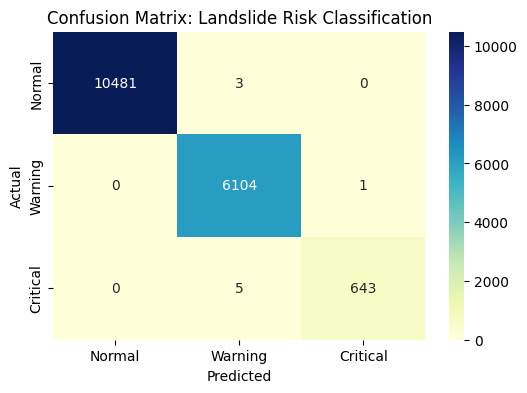

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Normal", "Warning", "Critical"],
            yticklabels=["Normal", "Warning", "Critical"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Landslide Risk Classification")
plt.show()

In [13]:
cv_scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print("Cross-validation Accuracies:", cv_scores)
print("Mean Accuracy from CV:", round(cv_scores.mean(), 3))

Cross-validation Accuracies: [0.99889772 0.99106573 0.98874514 0.99889766 0.99994198]
Mean Accuracy from CV: 0.996


# Test with Test Data Set

In [14]:
test = pd.read_csv("data/dev101_prepared.csv")
test

,timestamp,devID,soil,rain,temp,humi,geo,unixt,lat,lng,...,soil_1d_mean,geo_1h_mean,geo_3h_mean,geo_6h_mean,geo_12h_mean,geo_1d_mean,soil_diff,geo_diff,soil_1h_std,geo_1h_std
0,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,1.746186e+09,8.637999,99.899010,...,28.849999,13.766517,13.766517,13.766517,13.766517,13.766517,-0.100000,1.532716,0.070711,1.083794
1,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,1.746186e+09,8.637998,99.899010,...,28.833333,14.068782,14.068782,14.068782,14.068782,14.068782,0.000000,0.140435,0.057735,0.928114
2,2025-05-02 11:42:28.667259,101.0,28.900000,0.0,34.250019,62.839169,15.995875,1.746186e+09,8.637998,99.899010,...,28.849999,14.550555,14.550555,14.550555,14.550555,14.550555,0.100000,1.322565,0.057735,1.225841
3,2025-05-02 11:42:40.117564,101.0,28.799999,0.0,34.185932,62.661785,19.812029,1.746186e+09,8.637998,99.899010,...,28.839999,15.602850,15.602850,15.602850,15.602850,15.602850,-0.100000,3.816154,0.054772,2.581402
4,2025-05-02 11:42:50.732852,101.0,28.900000,0.0,34.175251,63.481953,8.099698,1.746186e+09,8.637998,99.899010,...,28.849999,14.352324,14.352324,14.352324,14.352324,14.352324,0.100000,-11.712331,0.054772,3.835856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79429,2025-06-12 10:46:33.972364,101.0,46.500000,0.0,30.025562,71.677956,19.938877,1.749750e+09,8.638006,99.898964,...,49.624622,8.968554,8.968554,8.913557,10.336119,9.672160,0.000000,11.428658,0.092314,5.304398
79430,2025-06-12 10:46:44.586807,101.0,46.500000,0.0,30.033573,71.571144,17.543438,1.749750e+09,8.638006,99.898964,...,49.623919,9.070635,9.070635,8.940651,10.339930,9.674623,0.000000,-2.395439,0.093015,5.354716
79431,2025-06-12 10:46:55.890011,101.0,46.500000,0.0,30.049595,71.706566,7.357331,1.749750e+09,8.638005,99.898964,...,49.623216,9.050479,9.050479,8.943975,10.342565,9.673334,0.000000,-10.186107,0.093665,5.325990
79432,2025-06-12 10:47:06.507349,101.0,46.700001,0.0,30.092319,71.382309,4.293847,1.749750e+09,8.638005,99.898964,...,49.622548,8.995169,8.995169,8.923403,10.343452,9.670699,0.200001,-3.063484,0.093364,5.319355


In [17]:
def risk_score(row):
    score = 0
    
    # soil moisture score
    if row['soil'] > 40:
        score += 3
    elif row['soil'] > 30:
        score += 2
    elif row['soil'] > 20:
        score += 1
    
    # rain in last 3 hours
    if row['rain_3h_sum'] > 20:
        score += 3
    elif row['rain_3h_sum'] > 10:
        score += 2
    elif row['rain_3h_sum'] > 5:
        score += 1
    
    # geo movement score
    if row['geo'] > 6:
        score += 3
    elif row['geo'] > 4:
        score += 2
    elif row['geo'] > 2:
        score += 1
    
    return score

# ้how to labeling
def classify_risk(row):
    score = risk_score(row)
    if score >= 8:
        return 2 #Critical
    elif score >= 5:
        return 1 #Warning
    else:
        return 0 #Normal

test['risk_level'] = test.apply(classify_risk, axis=1)

Accuracy of the model on test data: 0.95


C:\Users\ahmad\AppData\Local\Temp\ipykernel_26140\1644855296.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test, x='predicted_risk_level', palette='Set2')


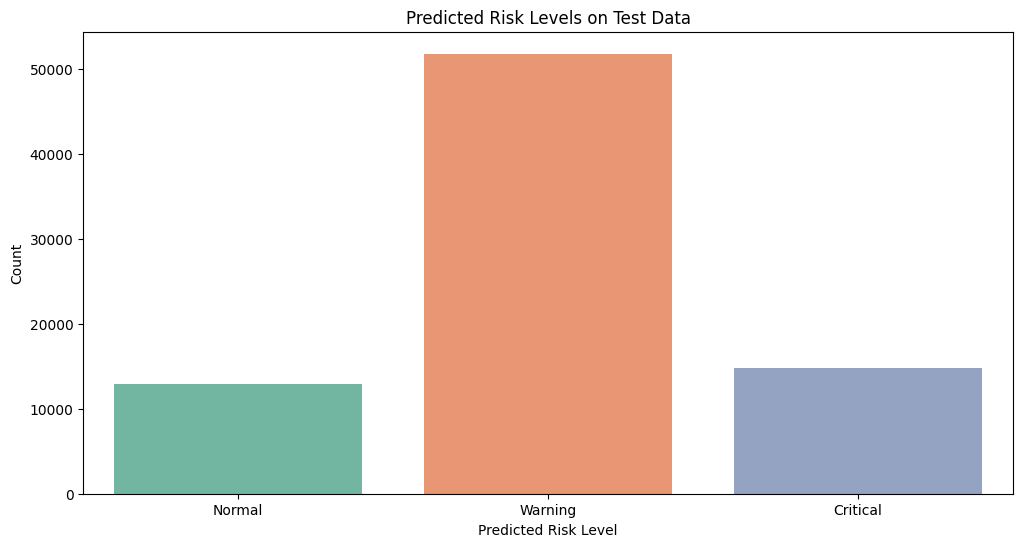

In [18]:
X_test_scaled = scaler.transform(test[features])
y_test_pred = clf.predict(X_test_scaled)
test['predicted_risk_level'] = y_test_pred

accuracy = accuracy_score(test['risk_level'], test['predicted_risk_level'])

print(f"Accuracy of the model on test data: {accuracy:.2f}")


plt.figure(figsize=(12, 6))
sns.countplot(data=test, x='predicted_risk_level', palette='Set2')
plt.title("Predicted Risk Levels on Test Data")
plt.xlabel("Predicted Risk Level")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Warning", "Critical"])
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

le = LabelEncoder()
y_true_encoded = le.fit_transform(test['risk_level'])
y_pred_encoded = le.transform(test['predicted_risk_level'])

r2 = r2_score(y_true_encoded, y_pred_encoded)

print(f"R-squared: {r2:.4f}")

R-squared: 0.8756


In [20]:
n = len(test)
k = len(features)
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

print(f"Adjusted R-squared: {r2_adj:.4f}")

Adjusted R-squared: 0.8756


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(test['risk_level'], test['predicted_risk_level']))
print(classification_report(test['risk_level'], test['predicted_risk_level']))


[[12867  3132     0]
 [    0 48624   573]
 [    0    51 14187]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     15999
           1       0.94      0.99      0.96     49197
           2       0.96      1.00      0.98     14238

    accuracy                           0.95     79434
   macro avg       0.97      0.93      0.94     79434
weighted avg       0.95      0.95      0.95     79434



In [22]:
def adjusted_r2(x,y):
    r2 = clf.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

print(adjusted_r2(X,y))

C:\Users\ahmad\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.03731516192043394
